In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
from scipy import sparse
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_test = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access
5,Аксессуары - PSVita,5,Access
6,Аксессуары - XBOX 360,6,Access
7,Аксессуары - XBOX ONE,7,Access
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [5]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [7]:
df_train = df_train.merge(df_item_bigcat, 'left')
# df_train.loc[:, 'item_category_id'] = df_train.loc[:, 'item_category_id'].fillna(-1).astype(int)
print(df_train.shape)
df_train.head()

(2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,bigcat
0,02.01.2013,0,59,22154,999.00,1.0,37,Movie
1,03.01.2013,0,25,2552,899.00,1.0,58,Music
2,05.01.2013,0,25,2552,899.00,-1.0,58,Music
3,06.01.2013,0,25,2554,1709.05,1.0,58,Music
4,15.01.2013,0,25,2555,1099.00,1.0,56,Music


In [8]:
df_test = df_test.merge(df_item_bigcat, 'left')
# df_test.loc[:, 'item_category_id'] = df_test.loc[:, 'item_category_id'].fillna(-1).astype(int)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat
0,0,5,5037,19,Consoles Games
1,1,5,5320,55,Music
2,2,5,5233,19,Consoles Games
3,3,5,5232,23,Consoles Games
4,4,5,5268,20,Consoles Games


In [9]:
junk_cats = [0,1,10,27,50,51,52]

In [10]:
print(set(df_train['item_category_id']) - set(df_test['item_category_id']))

print(set(df_test['item_category_id']) - set(df_train['item_category_id']))

zero_cnt_cats = set(df_train['item_category_id']) - set(df_test['item_category_id'])

{1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82}
set()


In [11]:
drop_cats = junk_cats + list(zero_cnt_cats)
df_train = df_train.loc[~df_train['item_category_id'].isin(drop_cats)]
df_train.shape

(2904353, 8)

In [12]:
print(sorted(set(df_train['shop_id']) - set(df_test['shop_id'])))
print(set(df_test['shop_id']) - set(df_train['shop_id']))
junk_shops = sorted(set(df_train['shop_id']) - set(df_test['shop_id']))
df_train = df_train.loc[~df_train['shop_id'].isin(junk_shops)]
df_train.shape

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
set()


(2389017, 8)

In [13]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.reset_index(inplace=True)
df_train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [14]:
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

# fill non-shown item

In [15]:
test_item_set = set(df_test['item_id'])
train_shops = df_train_piv['shop_id'].drop_duplicates().values

In [16]:
df_train_piv_append = df_train_piv.head(0)

for shid in train_shops:
    have_items = set(df_train_piv.loc[df_train_piv['shop_id'] == shid, 'item_id'])
    need_items = list(test_item_set - have_items)
    tmp_arr = np.zeros((len(need_items), 36))
    tmp_arr[:, 0] = shid
    tmp_arr[:, 1] = need_items
    df_train_piv_append = df_train_piv_append.append(pd.DataFrame(tmp_arr, columns=df_train_piv_append.columns))

In [17]:
df_train_piv = df_train_piv.append(df_train_piv_append)
df_train_piv.loc[:, 'shop_id'] = df_train_piv.loc[:, 'shop_id'].astype(np.int32)
df_train_piv.loc[:, 'item_id'] = df_train_piv.loc[:, 'item_id'].astype(np.int32)

In [18]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="left", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,Consoles Games
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,Movie
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40,Movie
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,37,Movie


In [19]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [20]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [21]:
# %load_ext autoreload
# %autoreload 2
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

In [22]:
# clip
df_train_piv.iloc[:, 4:] = df_train_piv.iloc[:, 4:].clip(0, 20)
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
df_train_piv.loc[df_train_piv['shop_id'] == 36, 32] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
df_train_piv.loc[df_train_piv['shop_id'] == 36, 31] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]

# check shops

In [19]:
check_shop_ids = [34, 36, 39, 48, 49]

for shid in check_shop_ids:
    print(shid, df_train_piv[df_train_piv['shop_id'] == shid].shape, df_test[df_test['shop_id'] == shid].shape)


34 (1847, 38) (5100, 5)
36 (258, 38) (5100, 5)
39 (4077, 38) (5100, 5)
48 (4048, 38) (5100, 5)
49 (3761, 38) (5100, 5)


In [24]:
df_shop_months = df_train_piv.groupby('shop_id').sum()
df_shop_months.drop(['item_id', 'item_category_id', 'bigcat'], axis=1, inplace=True)

df_shop_months

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
2,1107.0,481.0,734.0,571.0,537.0,782.0,796.0,846.0,841.0,713.0,...,945.0,881.0,746.0,685.0,713.0,773.0,762.0,942.0,802.0,717.0
3,762.0,795.0,958.0,644.0,697.0,745.0,682.0,862.0,926.0,768.0,...,955.0,737.0,724.0,679.0,699.0,658.0,532.0,637.0,617.0,613.0
4,1950.0,1883.0,1912.0,268.0,1139.0,1367.0,1343.0,1679.0,1404.0,1371.0,...,1098.0,922.0,903.0,778.0,797.0,759.0,812.0,868.0,687.0,748.0
5,0.0,866.0,1346.0,1003.0,1099.0,1323.0,1221.0,1488.0,1247.0,1214.0,...,1290.0,1070.0,1094.0,875.0,950.0,934.0,956.0,1246.0,1028.0,1029.0
6,3437.0,3630.0,3860.0,2906.0,2791.0,3315.0,3004.0,3254.0,3304.0,2990.0,...,2224.0,2195.0,1904.0,1582.0,1430.0,1497.0,1440.0,1522.0,1565.0,1676.0
7,2470.0,2470.0,2349.0,1530.0,1595.0,1965.0,1930.0,2290.0,2252.0,1984.0,...,1928.0,1701.0,1351.0,1166.0,1085.0,1196.0,1274.0,1376.0,1227.0,1169.0
10,894.0,992.0,966.0,738.0,647.0,718.0,749.0,703.0,893.0,923.0,...,583.0,0.0,537.0,501.0,429.0,441.0,434.0,442.0,502.0,428.0
12,785.0,1054.0,1165.0,1227.0,807.0,1172.0,709.0,928.0,1285.0,1409.0,...,1444.0,1431.0,1275.0,1388.0,1015.0,1354.0,1108.0,1268.0,1611.0,1268.0
14,1701.0,1705.0,1793.0,1242.0,1351.0,1641.0,1524.0,1884.0,686.0,1226.0,...,1131.0,941.0,937.0,775.0,788.0,937.0,897.0,1030.0,986.0,941.0


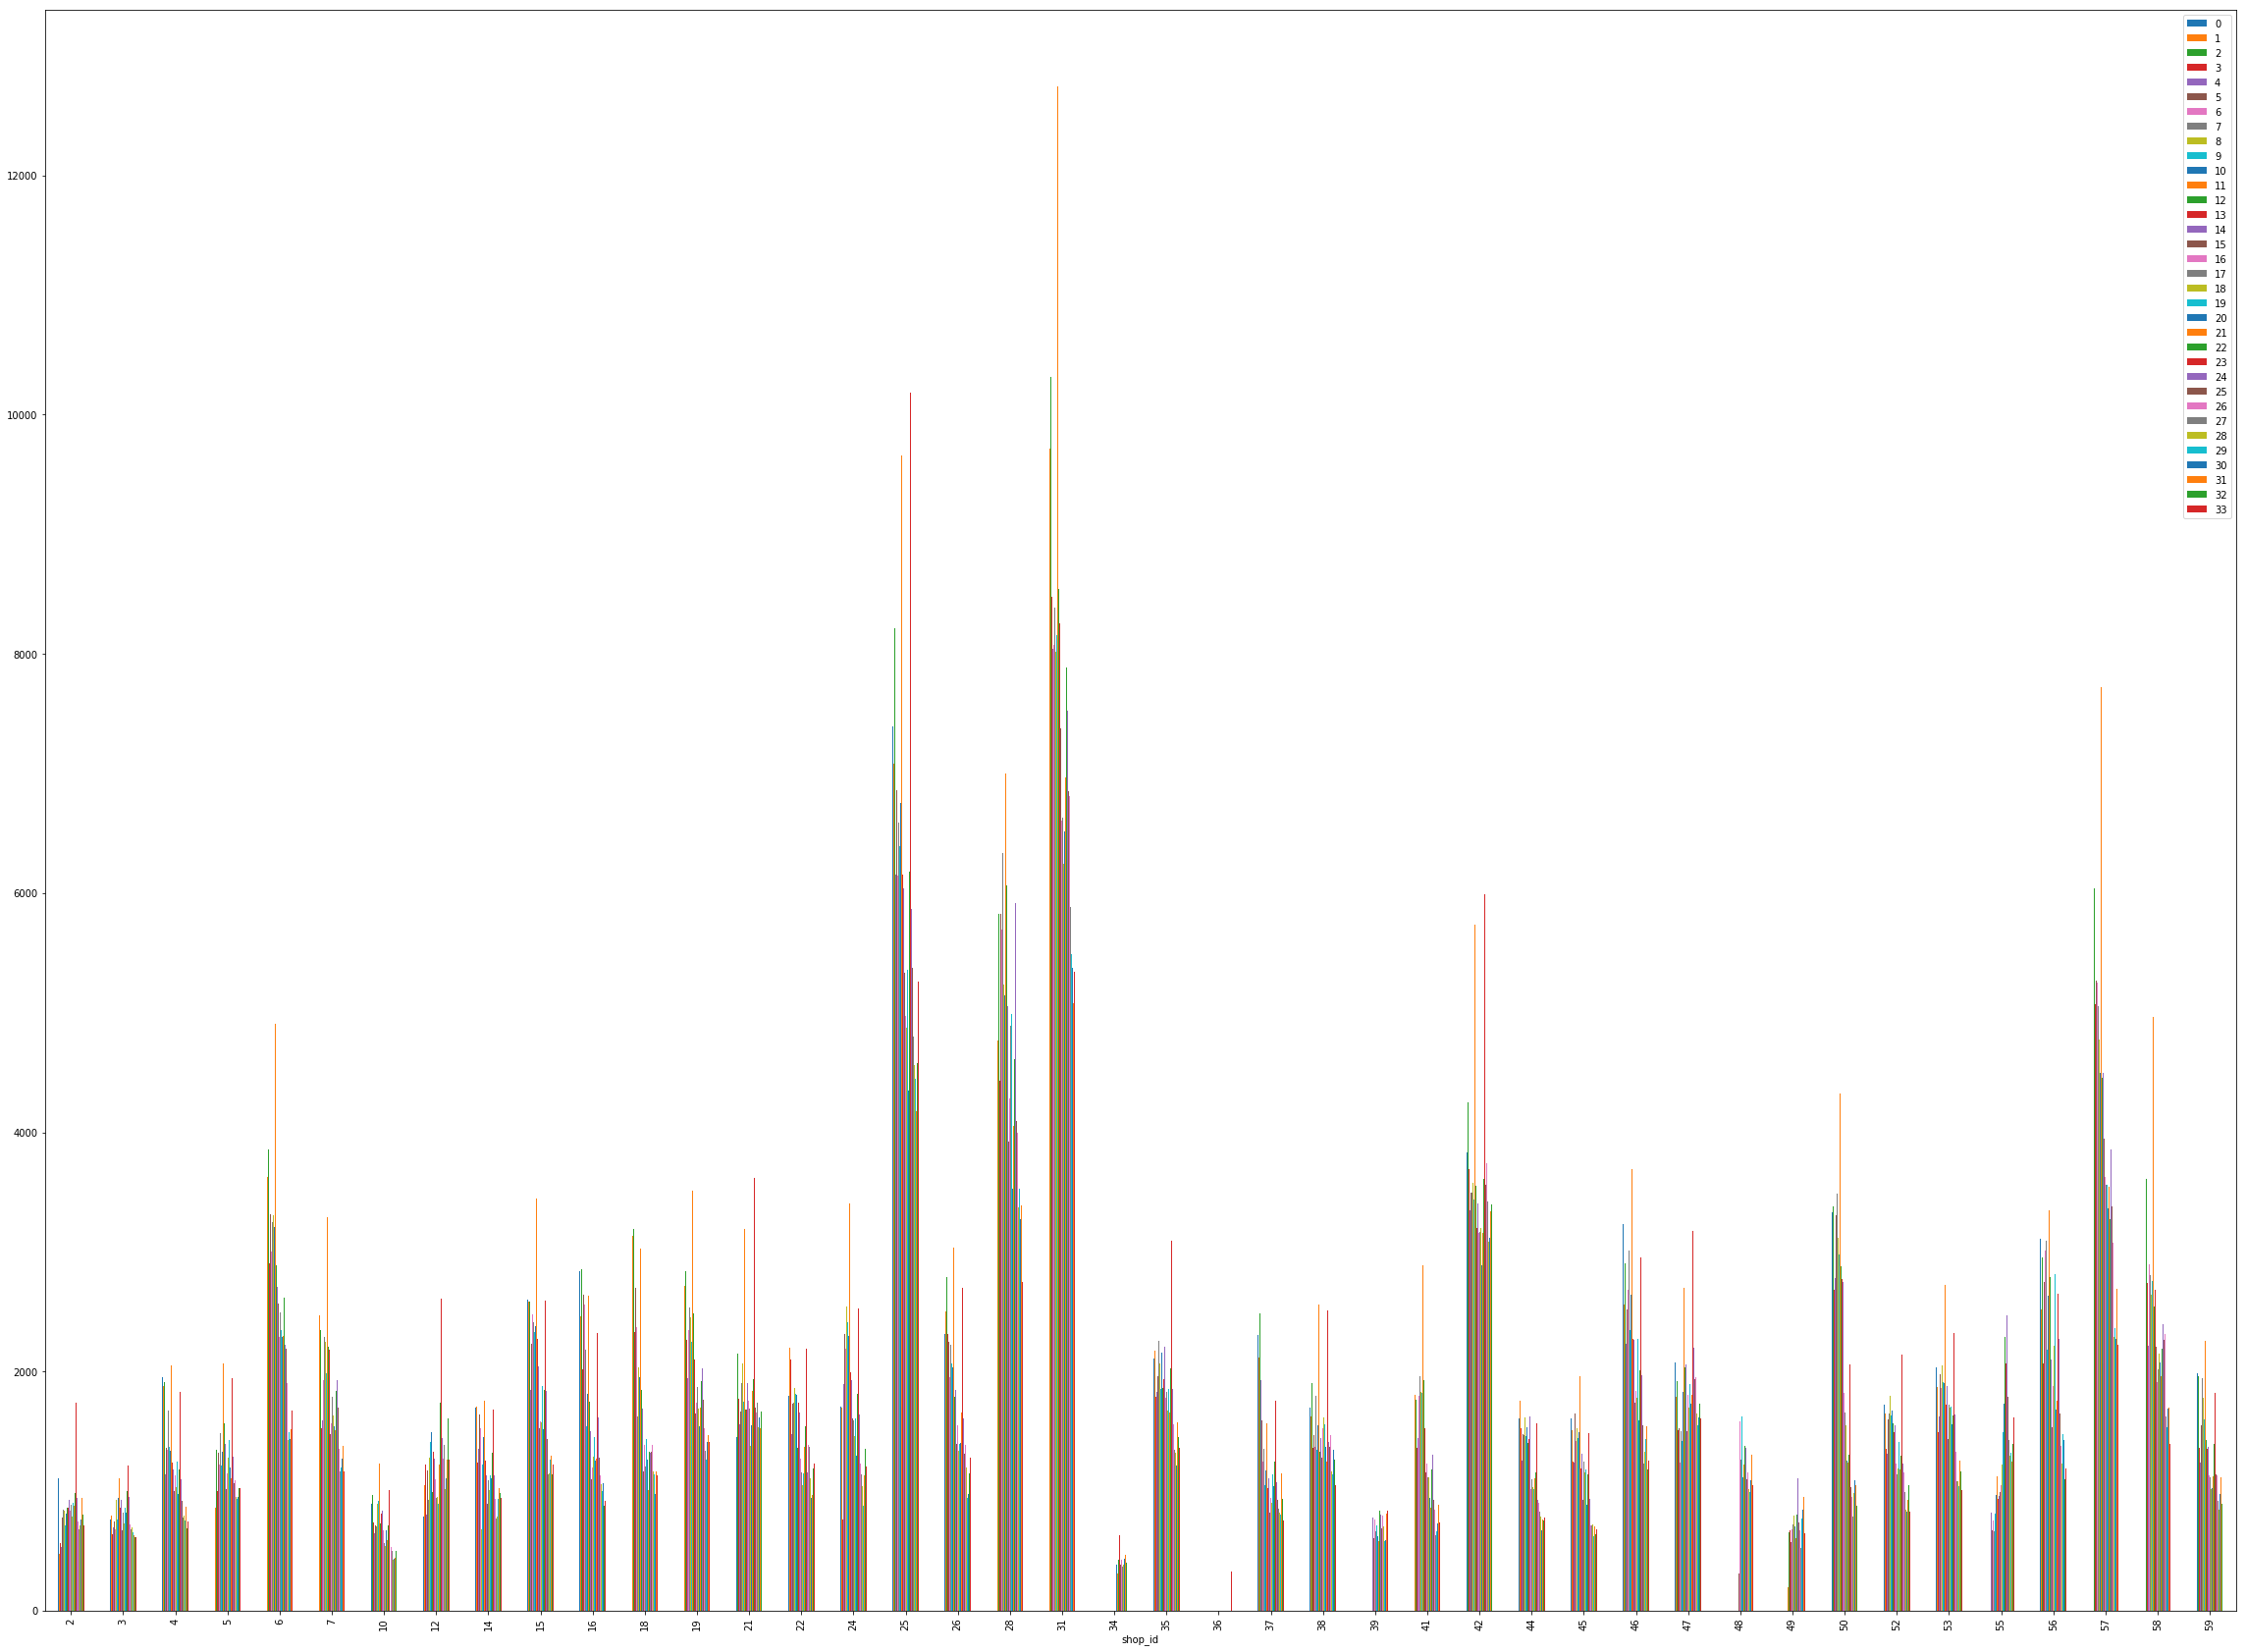

In [21]:
df_shop_months.plot.bar(figsize=(40, 30))

In [25]:
# df_shop_months = df_shop_months.pct_change(axis=1)
# df_shop_months[df_shop_months > 100] = 1
#df_shop_months.plot.bar(figsize=(40, 30))

# Preprocess categories

In [26]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                42
item_id             20813
item_category_id       62
bigcat                 16
dtype: int64

In [27]:
df_cats.loc[:, 'shop_item'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_id'].astype(str)
df_cats.loc[:, 'shop_category'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_category_id'].astype(str)
df_cats.loc[:, 'shop_bigcat'] = df_cats['shop_id'].astype(str) + '_' + df_cats['bigcat'].astype(str)
df_cats.head()

,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,2,27,19,5,2_27,2_19,2_5
1,2,30,40,7,2_30,2_40,2_7
2,2,31,37,7,2_31,2_37,2_7
3,2,32,40,7,2_32,2_40,2_7
4,2,33,37,7,2_33,2_37,2_7


In [28]:
from sklearn.preprocessing import OneHotEncoder
onehot_enc = OneHotEncoder()
# onehot_cols = df_cats.columns[df_cats.columns != 'item_id'].tolist()
onehot_cols = ['shop_id', 'item_category_id']
X_onehot = onehot_enc.fit_transform(df_cats.loc[:, onehot_cols])

In [29]:


# ###########
label_cols = list(set(df_cats.columns.tolist()) - set(onehot_cols))
df_cats = df_cats.astype('category').astype(np.int32)
df_labels = df_cats[label_cols]
X_label = sparse.csr_matrix(df_labels.values)


In [30]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [58]:
def expanding_mean_encoding(df, group_cols, target_col=None):
    if not target_col:
        target_col = df.columns[-1]
    cumsum = df.groupby(group_cols)[target_col].cumsum() - df[target_col]
    cumcnt = df.groupby(group_cols)[target_col].cumcount()
    return (cumsum / cumcnt).to_dict()

In [59]:
def mean_encoding(df, group_cols, target_col=None):
    if not target_col:
        target_col = df.columns[-1]
    return df.groupby(group_cols)[target_col].mean().to_dict()

In [60]:
label_cols = ['item_id']
# map_dict = mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)
map_dict = expanding_mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)

X_label = sparse.csr_matrix(df_train_piv[label_cols[0]].map(map_dict))
X_label = X_label.transpose()

<class 'pandas.core.series.Series'>


In [31]:
def period_column_feats(X, period=12):
    n_col = X.shape[1]
    feats = []

    for i in range(12):
        cols = [i]
        j = 1
        while i + j * period < n_col:
            cols.append(i + j * period)
            j += 1
        feats.extend([X[:, cols].mean(axis=1), X[:, cols].max(axis=1), X[:, cols].min(
            axis=1), X[:, cols].std(axis=1), np.median(X[:, cols], axis=1)])
    return np.column_stack(feats)


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def addtion_num_cols(X):
    return np.column_stack(
            (np.mean(X, axis=1),
             np.mean(X[:, -3:], axis=1), 
             np.mean(X[:, -6:], axis=1), 
             np.mean(X[:, -12:], axis=1),
             np.std(X, axis=1),
             np.std(X[:, -3:], axis=1), 
             np.std(X[:, -6:], axis=1), 
             np.std(X[:, -12:], axis=1),
#              np.nan_to_num(np.diff(X[:, -12:], axis=1) / X[:, -12:-1]) #pctchage
#              np.nan_to_num(np.diff(X, axis=1) / X[:, :-1]) #pctchage
#              np.apply_along_axis(running_mean, 1, X, N=3),
#              np.apply_along_axis(running_mean, 1, X, N=6),
            ))

In [32]:
def num_cols(X):
    X_diff = np.diff(X, axis=1)
    X_period = period_column_feats(X)
    
    X_ad = addtion_num_cols(X)
    X_diff_ad = addtion_num_cols(X_diff)
    X_period_ad = addtion_num_cols(X_period)
    
    return sparse.csr_matrix(np.column_stack((
        X,
        X_diff,
        X_period,
        X_ad,
        X_diff_ad,
        X_period_ad
    )))    

In [33]:
def predict_func(xm, bsts):
    preds = []
    for bst in bsts:
        preds.append(bst.predict(xm, ntree_limit=bst.best_ntree_limit))
    return np.mean(np.column_stack(preds), axis=1)

In [34]:
training_flag = True
# training_flag = False
n_months = 25



if training_flag:
    train_cols = [-3]
#     train_cols = [-6, -5, -4, -3, -2, -1]
else:
    train_cols = [-2, -1]
for train_col in train_cols:
    X_train = df_months.iloc[:, train_col - n_months:train_col].values
    X_train = sparse.hstack((X_onehot, X_label, num_cols(X_train)))

    y_train = df_months.iloc[:, train_col].values
#     y_train = df_months.iloc[:, train_col].values - df_months.iloc[:, train_col-1].values
    if train_col == train_cols[0]:
        X_train_cum, y_train_cum = X_train, y_train
    else:
        X_train_cum = sparse.vstack((X_train_cum, X_train), format='csr')
        y_train_cum = np.concatenate((y_train_cum, y_train))

print(X_train_cum.shape)

(435427, 242)


In [35]:
gc.collect()

14

In [36]:
if training_flag:
    val_col = train_cols[-1] + 1
else:
    val_col = train_cols[-1]
X_val = df_months.iloc[:, val_col - n_months:val_col].values
X_val = sparse.hstack((X_onehot, X_label, num_cols(X_val)))
y_val = df_months.iloc[:, val_col].values
# y_val = df_months.iloc[:, val_col].values - df_months.iloc[:, val_col-1].values

In [37]:
last_col = -1
X_last = df_months.iloc[:, last_col - n_months:last_col].values
X_last = sparse.hstack((X_onehot, X_label, num_cols(X_last)))
y_last = df_months.iloc[:, last_col].values

# xgblast = xgb.DMatrix(X_last)

# xgbost

In [38]:
bsts = []
df_limit = pd.DataFrame(columns=['i', 'limit'])

param = {'max_depth': 6,
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         #          'min_child_weight':0.5,
         'eta': 0.2,
         'seed': 1,
         'eval_metric': 'rmse'}


# xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
# xgbval = xgb.DMatrix(X_val, y_val)


n_trees = 1
xgbval = xgb.DMatrix(X_val, y_val)
tree_limit_choices = [20, 25, 30, 35]

last_rmses = []

for i in range(n_trees):

#     np.random.seed(i)
#     idxes = np.random.choice(X_train_cum.shape[0], X_train_cum.shape[0])
#     X_train_sample = X_train_cum[idxes]
#     y_train_sample = y_train_cum[idxes]
#     xgbtrain = xgb.DMatrix(X_train_sample, y_train_sample)
#     bst = xgb.train(param, xgbtrain, num_boost_round=np.random.choice(tree_limit_choices))

    xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
    watchlist = [(xgbtrain, 'train'), (xgbval, 'val')]
    bst = xgb.train(param, xgbtrain, num_boost_round=100,evals=watchlist, early_stopping_rounds=10, verbose_eval=1)

    bsts.append(bst)
#     bst.save_model('models/{}.model'.format(i))
#     df_limit.loc[df_limit.shape[0]] = [i, bst.best_ntree_limit]
#     df_limit.to_csv('models/df_limit.csv', index=False)

    preds_val = predict_func(xgbval, bsts)
    preds_last = predict_func(xgblast, bsts)
    print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
        y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))
    last_rmses.append(np.sqrt(mean_squared_error(y_last, preds_last)))
    gc.collect()

del xgbval
gc.collect()

[0]	train-rmse:0.770177	val-rmse:0.843307
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.73157	val-rmse:0.810769
[2]	train-rmse:0.698445	val-rmse:0.78323
[3]	train-rmse:0.670367	val-rmse:0.759948
[4]	train-rmse:0.646467	val-rmse:0.740914
[5]	train-rmse:0.62545	val-rmse:0.724741
[6]	train-rmse:0.608127	val-rmse:0.71145
[7]	train-rmse:0.593408	val-rmse:0.700865
[8]	train-rmse:0.580761	val-rmse:0.692001
[9]	train-rmse:0.570404	val-rmse:0.6849
[10]	train-rmse:0.561306	val-rmse:0.678841
[11]	train-rmse:0.554114	val-rmse:0.674229
[12]	train-rmse:0.547914	val-rmse:0.670125
[13]	train-rmse:0.5427	val-rmse:0.667103
[14]	train-rmse:0.537881	val-rmse:0.66449
[15]	train-rmse:0.534102	val-rmse:0.662609
[16]	train-rmse:0.530933	val-rmse:0.660937
[17]	train-rmse:0.528087	val-rmse:0.66
[18]	train-rmse:0.525742	val-rmse:0.658934
[19]	train-rmse:0.523632	val-rmse:0.657956
[20]	train-rmse:0.5218

0

In [39]:
bst.best_ntree_limit

36

In [40]:
preds_last = predict_func(xgblast, bsts)
print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
    y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))

0 36 0.6552177 0.6307247


In [42]:
# bsts = []
# for i in range(n_trees):
#     bsts.append(xgb.Booster(model_file='models/{}.model'.format(i)))

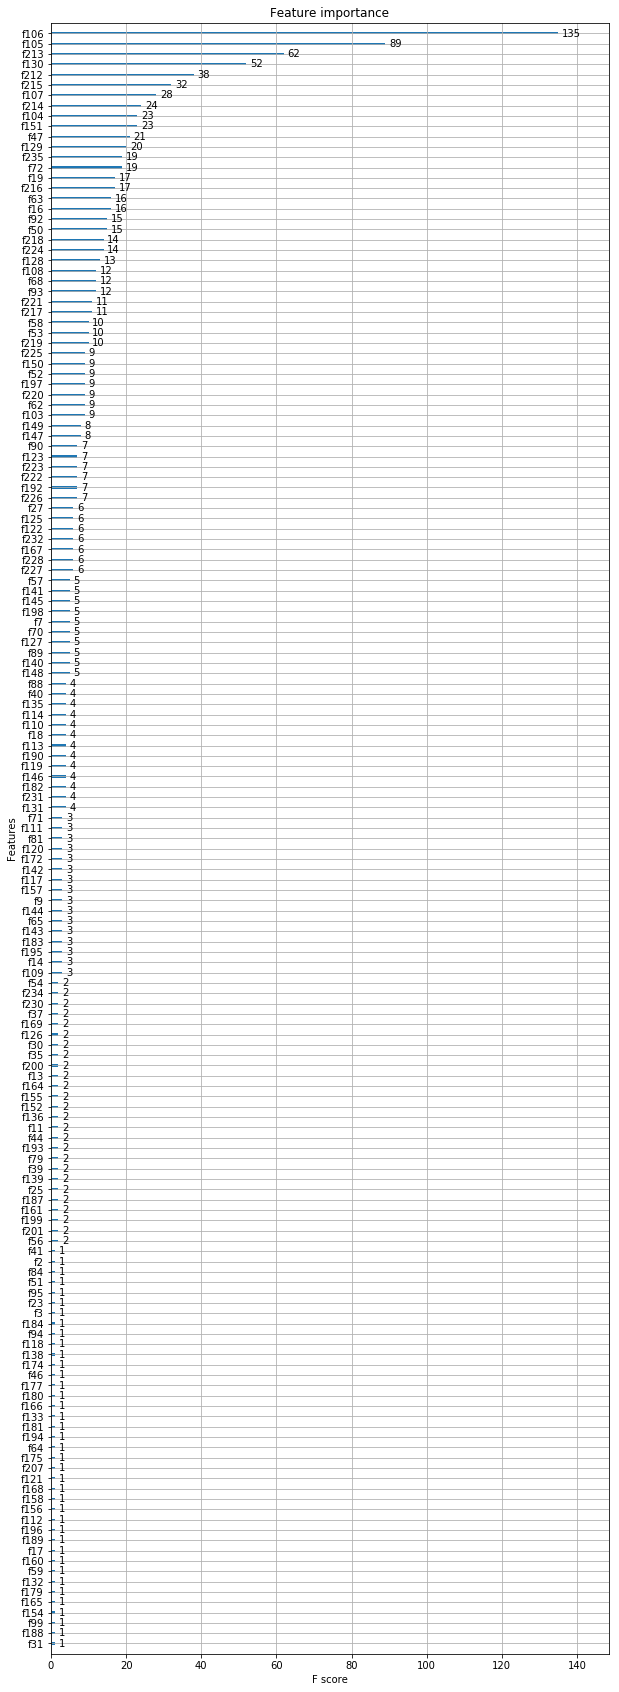

In [43]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(bst, figsize=(10, 30))

In [44]:
df_test = df_test.merge(df_train_piv[df_train_piv.columns[~df_train_piv.columns.isin(['item_category_id', 'bigcat'])]], how = "left", on = ["shop_id", "item_id"])
df_test[['bigcat']] = number.fit_transform(df_test.bigcat)
df_test.iloc[:, -34:] = df_test.iloc[:, -34:].fillna(0)

df_test_cats = df_test[['ID', 'shop_id', 'item_id']].merge(df_cats, how='left', on=['shop_id', 'item_id'])
df_test_cats.head()

,ID,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,0,5,5037,19,5,55037,519,55
1,1,5,5320,55,8,55320,555,58
2,2,5,5233,19,5,55233,519,55
3,3,5,5232,23,5,55232,523,55
4,4,5,5268,20,5,55268,520,55


In [45]:
X_test_label = sparse.csr_matrix(df_test_cats[label_cols].values)
X_test_label.shape

X_test_onehot = onehot_enc.transform(df_test_cats.loc[:, onehot_cols])
X_test = df_test.iloc[:, -n_months:].values
X_test = sparse.hstack((X_test_onehot, X_test_label, num_cols(X_test)))

xgbtest = xgb.DMatrix(X_test)

In [46]:
preds = predict_func(xgbtest, bsts)
preds = np.clip(preds, 0, 20)

In [52]:
# Normalize prediction to [0-20]
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [53]:
sub_df.head()

,ID,item_cnt_month
0,0,1.007006
1,1,0.162600
2,2,1.327407
3,3,0.261044
4,4,0.456020


# Random Forest

In [38]:
# y_val = np.log(y_val)
# y_train_cum = np.log(y_train_cum)
# y_last = np.log(y_last)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 100
rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=4)

train_scores = []
val_scores = []
for i in range(10, n_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(X_train_cum, y_train_cum)
    train_pred = rf.predict(X_train_cum)
    val_pred = rf.predict(X_val)
    train_score = np.sqrt(mean_squared_error(train_pred, y_train_cum))
    val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
    print(i, train_score, val_score)

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"